<a href="https://colab.research.google.com/github/YipengZou/Y_int_strategy/blob/main/Abnormal_volume_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. My plan today
1. First I will clean the dataset, calculate daily return and some other useful imformation.
2. I will divide the dataset into in-sample(training) and out-sample(validation) part. Construct the model based on training set and see how well the model works on validation set.
3. I will raise a research assumption so that I can investgate in. This assumption should be supported by market common sense, financial theory and simple validation based on this dataset.
4. I will first try some simple strategy, starting from one or two factor, and do the regression / statistics calculation to find whether there is obvious pattern between these factors and future return. If so, I can stick on it and investigate further.
5. After that, I will try to construct unlinear information, to make my model contains time information. Maybe I can try time series analysis instead of simple linear regression.
6. Based on a criteria I found the best model, then I will do the prdiction and see how it works in the validation set. If it works still good, I think this is a good strategy.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
mypath = "/content/drive/MyDrive/Y_intercept/data.csv"
data = pd.read_csv(mypath)
data['date'] = pd.to_datetime(data['date'])
train = data[data['date']<pd.to_datetime('2019-01-01')]
validation = data[data['date']>=pd.to_datetime('2019-01-01')]
data.columns

Index(['ticker', 'date', 'last', 'volume'], dtype='object')

# Strategy 1:
- **Assumption:**bIf the trading volume today is much higher then previous average trading volumes, then I assume buying it today and hold for a period will have a significant alpha
- **Reason for this assumption:**: For a normal stock, its trading volume will not fluctuate a lot. If one day, its trading volume abnormally increases a lot, it means some "big traders" are trading in this stock. This may mean some good news will be released. I want to investigate if there is some intrinsic pattern.


## 1.1 Update Data
1. Calculate past 1 day return, next 1, 5, 10 day return for each stock
2. Calculate previous 5 day average trading volumes
3. 

In [2]:
def update_data(temp):
  temp['return_prev1d'] = temp['last']/ temp['last'].shift(1)
  temp['return_prev5d'] = temp['last']/ temp['last'].shift(5)
  temp['return_nxt1d'] = temp['last'].shift(-1) / temp['last']  # Invest today, return
  temp['return_nxt5d'] = temp['last'].shift(-5) / temp['last']
  temp['return_nxt10d'] = temp['last'].shift(-10) / temp['last']
  temp['return_nxt20d'] = temp['last'].shift(-20) / temp['last']
  temp['return_nxt30d'] = temp['last'].shift(-30) / temp['last']
  temp['volume_prev5'] = temp['volume'].rolling(5, closed='left').mean()
  return temp[1:]

update = train.groupby("ticker").apply(lambda x: update_data(x))  # Calculate return

## 1.2 Calculate market return
1. For each day, I compare the trading volume of a stock and all the stocks
2. I calculate the proportion of its trading volume as its market weight. And use this weighted return to calculate the market return.
3. I set the trading cost as 0.1% to make the index represent the real market. I will also set the trading cost as 0.1% for my strategy.

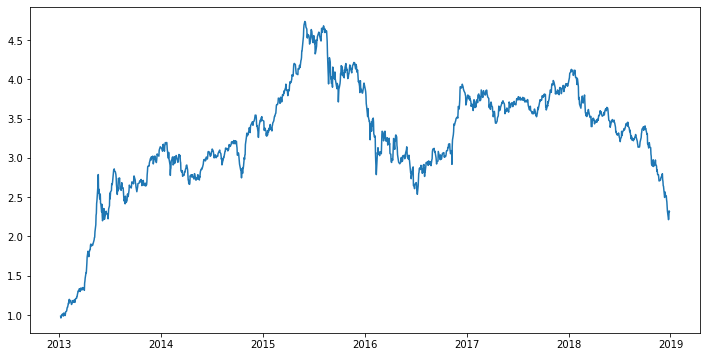

In [3]:
def index_return(temp):
  """Volume weighted return"""
  temp['volume_weight'] = temp['volume'] / temp['volume'].sum()
  return (temp['return_prev1d']*temp['volume_weight']).sum()
market_return = update.groupby('date').apply(lambda x: index_return(x))
plt.figure(figsize=(12,6))
plt.plot((market_return-0.001).cumprod())

## 1.3 Basic Strategy
- First I take a glance at the performance of my initial idea.
- I set the hyper-parameter, which determines the "abnormalness" of trading volume as 2. This means, I will take long position if today's trading volume is twice then the average trading volumes of this stock.
- In this basic strategy, I make some simplifications:
1. I will only hold long position. 
2. I will trade everyday. 
3. I will buy at the close price at the day when the abnormal trading volume occurs.
4. If I hold for x days, then each day I will invest 1/x\% of my position. Suppose I hold a portfolio for 10 days and the return rate of this portfolio is r, then its I will calculate the return on my account today as (r-0.001)/10

- I will use sharpe ratio to evaluate the strategy performance




Sharp Ratio for holding 1 day:  -0.0149
Sharp Ratio for holding 5 day:  0.0599
Sharp Ratio for holding 10 day:  0.1152
Sharp Ratio for holding 20 day:  0.1757
Sharp Ratio for holding 30 day:  0.2167
Market Sharp Ratio:  0.0435


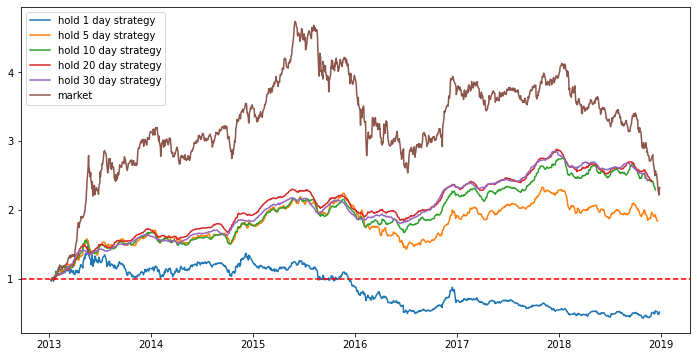

In [4]:
def get_sharp(daily_return):
  return round(daily_return.mean()/daily_return.std(),4)

def plot_strategy_return(daily_hold):
  plt.figure(figsize=(12,6))

  plt.plot(((daily_hold['return_nxt1d'].mean()-1-0.001)/1+1).cumprod(), label='hold 1 day strategy')
  print("Sharp Ratio for holding 1 day: ", get_sharp((daily_hold['return_nxt1d'].mean()-1-0.001)/1))
  plt.plot(((daily_hold['return_nxt5d'].mean()-1-0.001)/5+1).cumprod(), label='hold 5 day strategy')
  print("Sharp Ratio for holding 5 day: ", get_sharp((daily_hold['return_nxt5d'].mean()-1-0.001)/5))
  plt.plot(((daily_hold['return_nxt10d'].mean()-1-0.001)/10+1).cumprod(), label='hold 10 day strategy')
  print("Sharp Ratio for holding 10 day: ", get_sharp((daily_hold['return_nxt10d'].mean()-1-0.001)/10))
  plt.plot(((daily_hold['return_nxt20d'].mean()-1-0.001)/20+1).cumprod(), label='hold 20 day strategy')
  print("Sharp Ratio for holding 20 day: ", get_sharp((daily_hold['return_nxt20d'].mean()-1-0.001)/20))
  plt.plot(((daily_hold['return_nxt30d'].mean()-1-0.001)/30+1).cumprod(), label='hold 30 day strategy')
  print("Sharp Ratio for holding 30 day: ", get_sharp((daily_hold['return_nxt30d'].mean()-1-0.001)/30))
  plt.plot((market_return-0.001).cumprod(), label='market')
  plt.axhline(1, c='r',ls='--')
  print("Market Sharp Ratio: ", get_sharp((market_return-0.001-1)))
  plt.legend()
  return

daily_hold1 = update[update['volume']>2*update['volume_prev5']].groupby('date')
plot_strategy_return(daily_hold1)

### 1.3.1 Discussion
- From simple implementation I found my strategy can beat the index in term of sharpe ratio. It has a more stable return curve.
- However, the absolute return can not beat the market and the sharpe ratio is still low. I want to investigate the detail of this strategy.
- I found the longer I held, the better performance I can get.
- First I investigate the daily holding detail. I will optimize in two ways:
1. Somedays the holding number is too much. This may because that day, the market is booming and abnormal, and maybe this signal is invalid at that day. Thus, I will discard these signals. By doing this, I found the sharp ratio increases a little.

Sharp Ratio for holding 1 day:  -0.0228
Sharp Ratio for holding 5 day:  0.061
Sharp Ratio for holding 10 day:  0.1242
Sharp Ratio for holding 20 day:  0.1861
Sharp Ratio for holding 30 day:  0.2201
Market Sharp Ratio:  0.0435


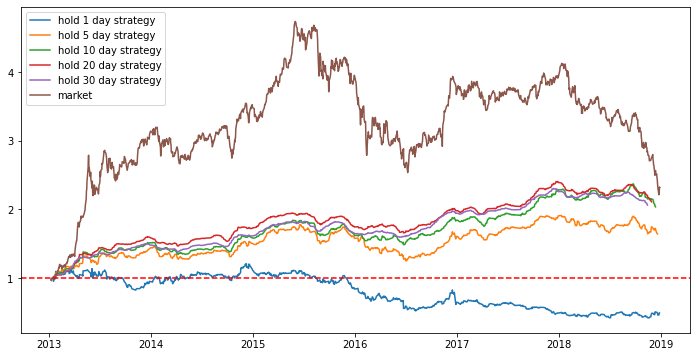

In [5]:
# plt.boxplot(daily_hold.count()['ticker'])
daily_hold1.count().describe()['ticker']
# np.where(daily_hold.count()['ticker']>20)
def count_abnormal_num(temp):
  temp['abnormal_number'] = temp.shape[0]
  return temp
daily_hold2 = update[update['volume']>2*update['volume_prev5']].groupby('date').apply(lambda x: count_abnormal_num(x))
daily_hold2 = daily_hold2[daily_hold2['abnormal_number']<=10].groupby('date')
plot_strategy_return(daily_hold2)

### 1.3.2 Discussion
- Another method is to assign weights for each stock I want to buy. 
- Here I will use "abnormal rate", which measures the degree this stock's trading volume increases as the weight I invest each day.

Sharp Ratio for holding 1 day:  -0.0149
Sharp Ratio for holding 5 day:  0.0599
Sharp Ratio for holding 10 day:  0.1152
Sharp Ratio for holding 20 day:  0.1757
Sharp Ratio for holding 30 day:  0.2167
Market Sharp Ratio:  0.0435


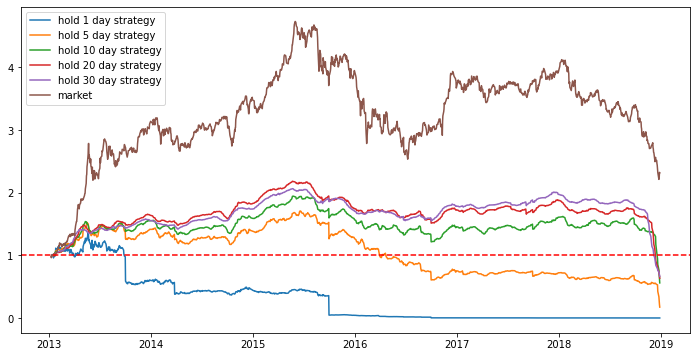

In [6]:
def cal_abnormal_prop(temp):
  temp['abnormal_prop'] = temp['abnormal_rate'] / temp['abnormal_rate'].sum()
  return temp

def plot_strategy_return2(daily_hold):
  plt.figure(figsize=(12,6))
  plt.plot(((daily_hold.apply(lambda x: (x['return_nxt1d']*x['abnormal_prop']).sum())-1-0.001)/1+1).cumprod(), label='hold 1 day strategy')
  print("Sharp Ratio for holding 1 day: ", get_sharp((daily_hold['return_nxt1d'].mean()-1-0.001)/1))
  plt.plot(((daily_hold.apply(lambda x: (x['return_nxt5d']*x['abnormal_prop']).sum())-1-0.001)/5+1).cumprod(), label='hold 5 day strategy')
  print("Sharp Ratio for holding 5 day: ", get_sharp((daily_hold['return_nxt5d'].mean()-1-0.001)/5))
  plt.plot(((daily_hold.apply(lambda x: (x['return_nxt10d']*x['abnormal_prop']).sum())-1-0.001)/10+1).cumprod(), label='hold 10 day strategy')
  print("Sharp Ratio for holding 10 day: ", get_sharp((daily_hold['return_nxt10d'].mean()-1-0.001)/10))
  plt.plot(((daily_hold.apply(lambda x: (x['return_nxt20d']*x['abnormal_prop']).sum())-1-0.001)/20+1).cumprod(), label='hold 20 day strategy')
  print("Sharp Ratio for holding 20 day: ", get_sharp((daily_hold['return_nxt20d'].mean()-1-0.001)/20))
  plt.plot(((daily_hold.apply(lambda x: (x['return_nxt30d']*x['abnormal_prop']).sum())-1-0.001)/30+1).cumprod(), label='hold 30 day strategy')
  print("Sharp Ratio for holding 30 day: ", get_sharp((daily_hold['return_nxt30d'].mean()-1-0.001)/30))
  plt.plot((market_return-0.001).cumprod(), label='market')
  plt.axhline(1, c='r',ls='--')
  print("Market Sharp Ratio: ", get_sharp((market_return-0.001-1)))
  plt.legend()
  return

daily_hold3 = update[update['volume']>2*update['volume_prev5']].groupby('date').apply(lambda x: count_abnormal_num(x))
daily_hold3['abnormal_rate'] = daily_hold3['volume'] / daily_hold3['volume_prev5']
daily_hold3 = daily_hold3.groupby('date').apply(lambda x: cal_abnormal_prop(x)).groupby('date')
plot_strategy_return2(daily_hold3)

### 1.4 Regression Model
- The strategy works not well in 1.3.2. The problem still lies in which stock I should choose to buy.
- I want to stick to my initial assumption, and use "abnormal trading volume" as a criteria to narrow my stock pool. 
- Based on the selection results, I will construct more factors and use these factors to predict the next 30 days return and determine which stock to buy.

### How do I consturct the prediction model:
1. I construct several features using the given data, including: (a) logarithm of trading amount, which is the product of close price and trading volume; (b) abnormal ratio; (c) previous 5 days return; (d) number of abnormal stocks that day
2. I want to construct a linear regression model, which will predict the next 1 day or 30 day return. The problem here is the time efficiency of training data. We should not use data that is 1000 days ago to train our predict model. Thus, I will use moving window to construct the training data and build the model.
3. How to construct the moving window? I will update the model everyday. The training data I used is the data during the past 60 days. Thus, when one day ends, I will add data today into the training set and pop out the data that is 61 days ago, to ensure the length of training period.
4. After getting the trained model, I will do the prediction at the end of this trading day. I will input the variables I got today and do the prediction. 
5. My simple trading strategy is sorting the prediction result. Then, buy the stock that receives highest prediction result, which means in my model it is supposed to gain the highest return.

In [7]:
daily_hold4 = update[update['volume']>2*update['volume_prev5']].groupby('date').apply(lambda x: count_abnormal_num(x))
daily_hold4 = daily_hold4.copy()
daily_hold4 = daily_hold4[daily_hold4['abnormal_number']<=20]  # Exclude some noises
daily_hold4['amount'] = np.log(daily_hold4['last'] * daily_hold4['volume'])  # Calculate trading amounts
daily_hold4['abnormal_ratio'] = daily_hold4['volume'] / daily_hold4['volume_prev5']
daily_hold4 = daily_hold4.sort_values(by='date')
dates = daily_hold4['date'].drop_duplicates().reset_index()['date']
record = pd.DataFrame(columns=['date', 'return'])
for i in range(1200):
  train = daily_hold4[daily_hold4['date']>=dates[0+i]]
  train = train[train['date']<dates[60+i]].dropna()
  test = daily_hold4[daily_hold4['date']==dates[61+i]]
  today = dates[61+i]

  X_train = train[['return_prev5d', 'amount', 'abnormal_ratio', 'abnormal_number']]
  X_test = test[['return_prev5d', 'amount', 'abnormal_ratio', 'abnormal_number']]
  y_train = train['return_nxt30d']
  y_test = test[['return_nxt30d']]
  reg = LinearRegression().fit(X_train, y_train)
  bar = reg.predict(X_train).mean()-0.01
  y_test = y_test.copy()
  y_test['predict'] = reg.predict(X_test)
  if y_test.shape[0] < 2:
    today_ret = y_test.iloc[0]['return_nxt30d']
  today_ret = y_test.sort_values(by='predict')[-1:]['return_nxt30d'].mean()
  record = record.append([{"date": today, "return": today_ret}])
record2 = pd.DataFrame(columns=['date', 'return'])
for i in range(1200):
  train = daily_hold4[daily_hold4['date']>=dates[0+i]]
  train = train[train['date']<dates[60+i]].dropna()
  test = daily_hold4[daily_hold4['date']==dates[61+i]]
  today = dates[61+i]

  X_train = train[['return_prev5d', 'amount', 'abnormal_ratio', 'abnormal_number']]
  X_test = test[['return_prev5d', 'amount', 'abnormal_ratio', 'abnormal_number']]
  y_train = train['return_nxt1d']
  y_test = test[['return_nxt1d']]
  reg = LinearRegression().fit(X_train, y_train)
  bar = reg.predict(X_train).mean()-0.01
  y_test = y_test.copy()
  y_test['predict'] = reg.predict(X_test)
  if y_test.shape[0] < 2:
    today_ret = y_test.iloc[0]['return_nxt1d']
  today_ret = y_test.sort_values(by='predict')[-2:]['return_nxt1d'].mean()
  record2 = record2.append([{"date": today, "return": today_ret}])
record3 = pd.DataFrame(columns=['date', 'return'])
for i in range(1200):
  train = daily_hold4[daily_hold4['date']>=dates[0+i]]
  train = train[train['date']<dates[60+i]].dropna()
  test = daily_hold4[daily_hold4['date']==dates[61+i]]
  today = dates[61+i]

  X_train = train[['return_prev5d', 'amount', 'abnormal_ratio', 'abnormal_number']]
  X_test = test[['return_prev5d', 'amount', 'abnormal_ratio', 'abnormal_number']]
  y_train = train['return_nxt5d']
  y_test = test[['return_nxt5d']]
  reg = LinearRegression().fit(X_train, y_train)
  y_test = y_test.copy()
  y_test['predict'] = reg.predict(X_test)
  if y_test.shape[0] < 2:
    today_ret = y_test.iloc[0]['return_nxt5d']
  today_ret = y_test.sort_values(by='predict')[-2:]['return_nxt5d'].mean()
  record3 = record3.append([{"date": today, "return": today_ret}])

Sharp Ratio for holding 1 day:  -0.0228
Sharp Ratio for holding 5 day:  0.0329
Sharp Ratio for holding 30 day:  0.1193


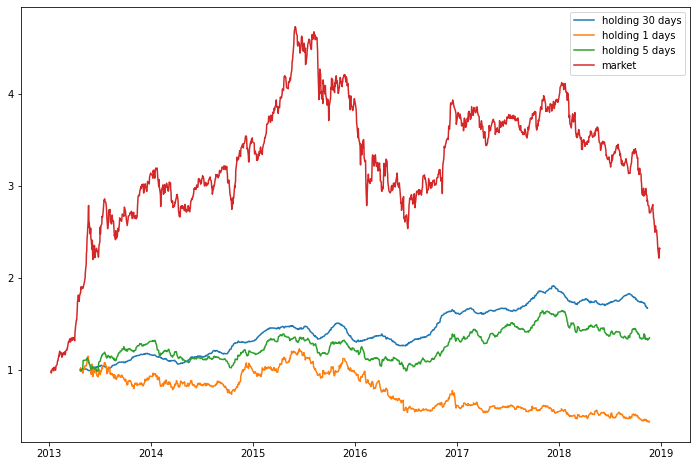

In [8]:
plt.figure(figsize=(12,8))
plt.plot(record['date'], ((record['return']-1-0.001)/30+1).cumprod(), label='holding 30 days')
plt.plot(record['date'], ((record2['return']-1-0.001)/1+1).cumprod(), label='holding 1 days')
plt.plot(record['date'], ((record3['return']-1-0.001)/5+1).cumprod(), label='holding 5 days')
print("Sharp Ratio for holding 1 day: ", get_sharp((record2['return']-1-0.001)/1))
print("Sharp Ratio for holding 5 day: ", get_sharp((record3['return']-1-0.001)/5))
print("Sharp Ratio for holding 30 day: ", get_sharp((record['return']-1-0.001)/30))
plt.plot((market_return-0.001).cumprod(), label='market')
plt.legend()

## 2. Prediction
- Based on above discussion, I found the second strategy works best. Thus, I want to test its out-sample performance and validate my strategy.
- The absolut return of strategy of holding 30 days is positive, and its sharpe ration can still beats the market.

Sharp Ratio for holding 1 day:  0.0044
Sharp Ratio for holding 5 day:  -0.0118
Sharp Ratio for holding 10 day:  0.0464
Sharp Ratio for holding 20 day:  0.0843
Sharp Ratio for holding 30 day:  0.0936
Market Sharp Ratio:  0.0399


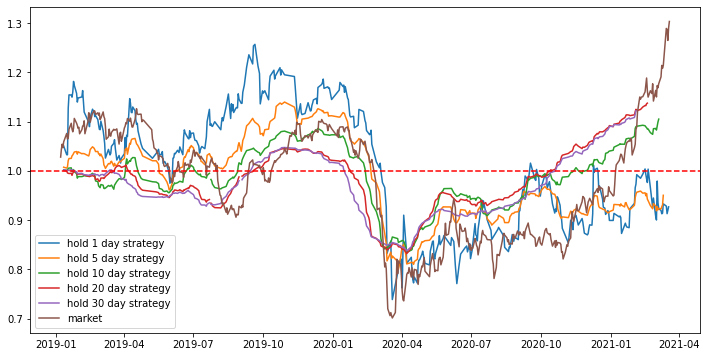

In [9]:
update2 = validation.groupby("ticker").apply(lambda x: update_data(x))  # Calculate return
daily_hold_pred = update2[update2['volume']>2*update2['volume_prev5']].groupby('date').apply(lambda x: count_abnormal_num(x))
daily_hold_pred = daily_hold_pred[daily_hold_pred['abnormal_number']<=10].groupby('date')
market_return = update2.groupby('date').apply(lambda x: index_return(x))
plot_strategy_return(daily_hold_pred)

## 3. Results
- My way to design a strategy is to first raise an assumption based on some observations or intrinsic logics, and then use previous data to validate whether my assumption is right. If it is partially right, I will look into the detail of this model to find where I can optimize. After that, I will use the out-sample data to do the validation and see how well the model works.
- Since this dataset only gives trading volume and close price, so I raise my assumption based on "abnormal trading volume". This is supported by some market common sense and my simple validation. Though the model does not work so well, I think it is an acceptable way to do the research.
- I think using moving window to construct a linear regression prediction model is a good way to construct a strategy. If I could have more time, I will optimize the model better.
- The model beats the market index in term of sharp ratio, with smaller volatility and drawdown. After considering trading cost and time cost, it can still generate positive return.

## 4. Next Step
- The number of data available in this task is limited. I could combine more features into the prediction model to make the predict results more precise and improve the strategy.
- I only consider the linear relationship in this strategy, there may exists some non-linear relationship.
- I did not consider the co-movement between different stocks. This can be done if given some fundamental factors. 